# Student Details

Name: Rahul Krishna Gajula

ID: D21124235

Course: TU059 (MSc in Computer Science: Data Science)

Year: First Year

# Link to Dataset:

This is the dataset used for this assignment, it consists of 2 files (Vehicle_Information.csv and Accident_Information.csv)
These files are made up of over 1.6 million records of vehicle accidents in the UK over the past few years. This dataset explores different factors of each accident, vehicle and driver which provides a good amount of depth for exploration and insights and that is why I have selected this dataset for this assignment

https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles

# User Story

This assignment and all the corresponding visualisations are targetted at those individuals who have decided to take up driving for the first time and those attneding driving schools for the first time.

Learning to drive and getting behind the wheel can be a very exciting experience to everyone, especially so if it is your first time doing so. However, there are several safety measures that we have to keep in mind so that a single moment of excitement does not turn to a tragedy.

The driver's mindset is the most important thing on the road. Each driver has to be in a stress free state and calm mind when they are driving so that they can complete their journey peacecully and safely.

For the purpose of this assignment, the following libraries are imported

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np
import pandas as pd
from datetime import datetime as dt
import time
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer, MaxAbsScaler
import seaborn as sns
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col,broadcast
from pyspark.sql import functions as F
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import squarify
init_notebook_mode(connected=True)
sns.set()
import math
import glob

warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

### Data Importing, Merging and Cleaning 

Over the next following cells, I have performed all the necessary steps read the data, merging to different datasets to produce the final dataframe, and perform data cleaning to increase the usability of dataframe 

Firstly, both the csv files of the dataset have to be read and imported into jupyter notebook and stored as two separate dataframes

In [2]:
df1 = pd.read_csv('Accident_Information.csv', encoding = 'unicode escape')
df2 = pd.read_csv('Vehicle_Information.csv', encoding = 'unicode escape')

The common column of Year is dropped from one of the csv files prior to merging

In [3]:
df1.drop('Year', axis = 1, inplace = True)

Both the dataframes are merged on the common column "Accident_Index" to produce one final dataframe which will be used for the rest of this assignment

In [4]:
df = pd.merge(df1 , df2 , on = 'Accident_Index', how = 'inner')

Over the next few cells, I have performed a good amount of data cleaning to this dataset which has made it suitable for me to use in this assignment.

The motivation and my thought process for each of the cleaning steps are clearly outlined in the comments in each code cell

In [5]:
#Columns Location_Easting_OSGR and Location_Northing_OSGR seem to be very similar to the Columns Longitude and Latitude
#respectively
#Therefore, i decided to check the correlation between the 4 columns to confirm my theory

#correlation between Location_Easting_OSGR & Location_Northing_OSGR AND Longitude & Latitude
print(df['Location_Easting_OSGR'].corr(df['Longitude']))
print(df['Location_Northing_OSGR'].corr(df['Latitude']))

0.9993670195112463
0.9999728865576533


In [6]:
#Since the correlation is extremely high, i have decided to remove Location_Easting_OSGR', 'Location_Northing_OSGR' to reduce
#redundance
#I then, show the shape of the dataframe to get an overall idea of what I am dealing with.
df = df.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR'], axis = 1)
print(df.shape)

(2058408, 54)


In [7]:
#Age_Band_of_Driver is one of the columns that I have decided to use for this assignment and i noticed that there are
#some strange values, therfore i decided to check and remove these strange values
df['Age_Band_of_Driver'].value_counts()

26 - 35                         424291
36 - 45                         408773
46 - 55                         331194
21 - 25                         226532
56 - 65                         195291
16 - 20                         165772
Data missing or out of range    162771
66 - 75                          87222
Over 75                          51996
11 - 15                           3559
6 - 10                             882
0 - 5                              125
Name: Age_Band_of_Driver, dtype: int64

In [8]:
#Underage drivers (0-15) and the "Data missing or out of range" values are dropped as they are of no use for this assignment
df.drop(df.index[df['Age_Band_of_Driver'] == 'Data missing or out of range'], inplace = True)
df.drop(df.index[df['Age_Band_of_Driver'] == '0 - 5'], inplace = True)
df.drop(df.index[df['Age_Band_of_Driver'] == '6 - 10'], inplace = True)
df.drop(df.index[df['Age_Band_of_Driver'] == '11 - 15'], inplace = True)

In [9]:
#Final values of "Age_Band_of_Drivers"
df['Age_Band_of_Driver'].value_counts()

26 - 35    424291
36 - 45    408773
46 - 55    331194
21 - 25    226532
56 - 65    195291
16 - 20    165772
66 - 75     87222
Over 75     51996
Name: Age_Band_of_Driver, dtype: int64

In [10]:
#Remove the "Unknown" value from Road_Type so that the visualisations make more sense
df.drop(df.index[df['Road_Type'] == 'Unknown'], inplace = True)

In [11]:
#Remove "Not known" and "Data missing out of range" values from "Sex_of_Driver" to enable side by side 
#comparision between male and female drivers
df.drop(df.index[df['Sex_of_Driver'] == 'Not known'], inplace = True)
df.drop(df.index[df['Sex_of_Driver'] == 'Data missing or out of range'], inplace = True)

In [12]:
df['Sex_of_Driver'].value_counts() 

Male      1297747
Female     577355
Name: Sex_of_Driver, dtype: int64

In [13]:
#checking the values of "Journey_Purpose_of_Driver" to see the reasons as to why people are on the road
df['Journey_Purpose_of_Driver'].value_counts()

Not known                       731424
Other/Not known (2005-10)       503003
Journey as part of work         372074
Commuting to/from work          198935
Other                            31372
Taking pupil to/from school      21024
Data missing or out of range     13935
Pupil riding to/from school       3335
Name: Journey_Purpose_of_Driver, dtype: int64

In [14]:
#Dropping Useless values to make sure that the visualisation makes sense
df.drop(df.index[df['Journey_Purpose_of_Driver'] == 'Not known'], inplace = True)
df.drop(df.index[df['Journey_Purpose_of_Driver'] == 'Data missing or out of range'], inplace = True)
df.drop(df.index[df['Journey_Purpose_of_Driver'] == 'Other/Not known (2005-10)'], inplace = True)
df.drop(df.index[df['Journey_Purpose_of_Driver'] == 'Other'], inplace = True)

In [15]:
#Checking Light_Conditions
df['Light_Conditions'].value_counts()

Daylight                        466962
Darkness - lights lit            91947
Darkness - no lighting           29401
Darkness - lighting unknown       4351
Darkness - lights unlit           2699
Data missing or out of range         8
Name: Light_Conditions, dtype: int64

In [16]:
#Dropping useless values from Light_Conditions
df.drop(df.index[df['Light_Conditions'] == 'Data missing or out of range'], inplace = True)

In [17]:
#convert Date to standatd Datetime format
df['Date']= pd.to_datetime(df['Date'], format="%Y-%m-%d")

In [18]:
#Creating an extra column to segregate the time into separate hours for further classifications

# slice first and second string from time column
df['Hour'] = df['Time'].str[0:2]

# convert new column to numeric datetype
df['Hour'] = pd.to_numeric(df['Hour'])

# drop null values in our new column
df = df.dropna(subset=['Hour'])

# cast to integer values
df['Hour'] = df['Hour'].astype('int')

In [19]:
# define a function that turns the hours into daytime groups
def time_of_day(hour):
    if hour >= 5 and hour < 10:
        return "Rush Hours(5-10)"
    elif hour >= 10 and hour < 15:
        return "Office Hours (10-15)"
    elif hour >= 15 and hour < 19:
        return "After Work Rush (15-19)"
    elif hour >= 19 and hour < 23:
        return "Evening (19-23)"
    else:
        return "Night (23-5)"

In [20]:
# apply thus function to our temporary hour column
df['Daytime'] = df['Hour'].apply(time_of_day)
df[['Time', 'Hour', 'Daytime']].head(5)

,Time,Hour,Daytime
0,17:36,17,After Work Rush (15-19)
1,00:15,0,Night (23-5)
14,10:50,10,Office Hours (10-15)
33,20:00,20,Evening (19-23)
41,17:36,17,After Work Rush (15-19)


In [21]:
#driver_imd_decile
df['Driver_IMD_Decile'].value_counts() 

2.0     45988
3.0     45047
4.0     44511
1.0     44159
5.0     43455
6.0     42645
7.0     40692
8.0     39575
9.0     38032
10.0    34086
Name: Driver_IMD_Decile, dtype: int64

In [22]:
#using ffill for Driver_IMD_Decile to ensure that there are no empty values in this column
df['Driver_IMD_Decile'].fillna(method = 'ffill', inplace = True)

In [23]:
#age_of_vehicle
df['Age_of_Vehicle'].value_counts()
df['Age_of_Vehicle'].describe()

count    487968.000000
mean          6.373123
std           4.435703
min           1.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          80.000000
Name: Age_of_Vehicle, dtype: float64

In [24]:
df['Age_of_Vehicle'].median()

6.0

In [25]:
#fill missing values with median vehicle age
df['Age_of_Vehicle'].fillna(7, inplace = True)

In [26]:
df['Engine_Capacity_.CC.'].mean()

2880.5466297996045

In [27]:
#fill missing values in "Engine_Capacity_.CC." with average engine capacity
df['Engine_Capacity_.CC.'].fillna(2028, inplace = True)

In [28]:
df.isnull().sum().sort_values(ascending = False)

2nd_Road_Class                                 249518
model                                          136718
Propulsion_Code                                 74761
LSOA_of_Accident_Location                       48012
make                                            20405
2nd_Road_Number                                  5890
Pedestrian_Crossing-Physical_Facilities           122
Pedestrian_Crossing-Human_Control                  93
Vehicle_Location.Restricted_Lane                   81
Longitude                                          32
Latitude                                           32
Did_Police_Officer_Attend_Scene_of_Accident        20
InScotland                                         13
Speed_limit                                        11
Driver_IMD_Decile                                   1
Towing_and_Articulation                             0
Driver_Home_Area_Type                               0
Engine_Capacity_.CC.                                0
Hour                        

In [29]:
#All other null values are dropped
df.dropna(inplace = True)
df.isnull().sum().sort_values(ascending = False)

Accident_Index                                 0
1st_Road_Class                                 0
InScotland                                     0
Age_Band_of_Driver                             0
Age_of_Vehicle                                 0
Driver_Home_Area_Type                          0
Driver_IMD_Decile                              0
Engine_Capacity_.CC.                           0
Hit_Object_in_Carriageway                      0
Hit_Object_off_Carriageway                     0
Journey_Purpose_of_Driver                      0
Junction_Location                              0
make                                           0
model                                          0
Propulsion_Code                                0
Sex_of_Driver                                  0
Skidding_and_Overturning                       0
Towing_and_Articulation                        0
Vehicle_Leaving_Carriageway                    0
Vehicle_Location.Restricted_Lane               0
Vehicle_Manoeuvre   

In [30]:
df.shape

(227564, 56)

In [31]:
df.head()

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year,Hour,Daytime
102,200501BS70175,A,3216.0,Unclassified,0.0,Slight,None,2005-04-22,Friday,3.0,...,Did not leave carriageway,0.0,Going ahead other,1,Taxi/Private hire car,No,Nearside,2005,20,Evening (19-23)
137,200501BS70239,Unclassified,0.0,Unclassified,0.0,Serious,None,2005-05-26,Thursday,1.0,...,Did not leave carriageway,0.0,Going ahead left-hand bend,1,Taxi/Private hire car,No,Nearside,2005,19,Evening (19-23)
168,200501BS70294,C,0.0,B,319.0,Slight,None,2005-06-15,Wednesday,2.0,...,Did not leave carriageway,0.0,Slowing or stopping,1,Taxi/Private hire car,No,Back,2005,16,After Work Rush (15-19)
194,200501BS70333,A,402.0,A,4206.0,Slight,None,2005-06-29,Wednesday,1.0,...,Did not leave carriageway,0.0,Changing lane to left,2,Taxi/Private hire car,No,Nearside,2005,23,Night (23-5)
276,200501BS70483,B,415.0,C,0.0,Slight,None,2005-08-31,Wednesday,1.0,...,Did not leave carriageway,0.0,Overtaking static vehicle - offside,1,Taxi/Private hire car,No,Front,2005,20,Evening (19-23)


In [32]:
#unique values
df.nunique().sort_values(ascending = False)

Accident_Index                                 195206
Longitude                                      174936
Latitude                                       172161
LSOA_of_Accident_Location                       30501
model                                           21304
2nd_Road_Number                                  5245
1st_Road_Number                                  4432
Date                                             4383
Time                                             1439
Engine_Capacity_.CC.                             1071
Local_Authority_(District)                        385
make                                              284
Local_Authority_(Highway)                         176
Age_of_Vehicle                                     46
Police_Force                                       44
Hour                                               24
Number_of_Casualties                               21
Vehicle_Manoeuvre                                  19
Vehicle_Type                

# Data Exploration

This section consists of several different graphs to provide an overall understanding of this dataset

In [33]:
#Creating smaller dataframes to show subplots of accidents which have happened due to factors that are out of the control of the driver

Weather_Conditions = df['Weather_Conditions'].value_counts()[:5]
Special_Conditions_at_Site = df['Special_Conditions_at_Site'].value_counts()[:5]
Road_Surface_Conditions = df['Road_Surface_Conditions'].value_counts()[:5]
Was_Vehicle_Left_Hand_Drive = df['Was_Vehicle_Left_Hand_Drive'].value_counts()[:5]
Skidding_and_Overturning = df['Skidding_and_Overturning'].value_counts()[:5]
Light_Conditions = df['Light_Conditions'].value_counts()[:5]

# Graph 1: Subplots of accident count vs different factors that may have caused the accident

The following subplots show the accident count against the following factors

Weather Condition - Shows the type of weather which may have led to the accident

Special Conditions at the site of accident - Was there any factors at the accident site which may have led to the accident happening?

Road Surface Conditions - How was the condition of the road when the accident happened?

Was the vehicle a left hand drive - What type of drive was the vehicle?

Skidding and Overturning - Was there any form of skidding and overturning involved in the accident

Light Conditions - Was visibility a factor in the accidents?

These factors are shown in the following subplots as they are best visualised as a group to provide a better understanding of some of the causes of road accidents that have take place in the UK over the past few years.

Please zoom in to see clearly as some of the labels factors explained with slightly long names and the font size is a little small.


Text(0.5, 1.0, 'Light_Conditions')

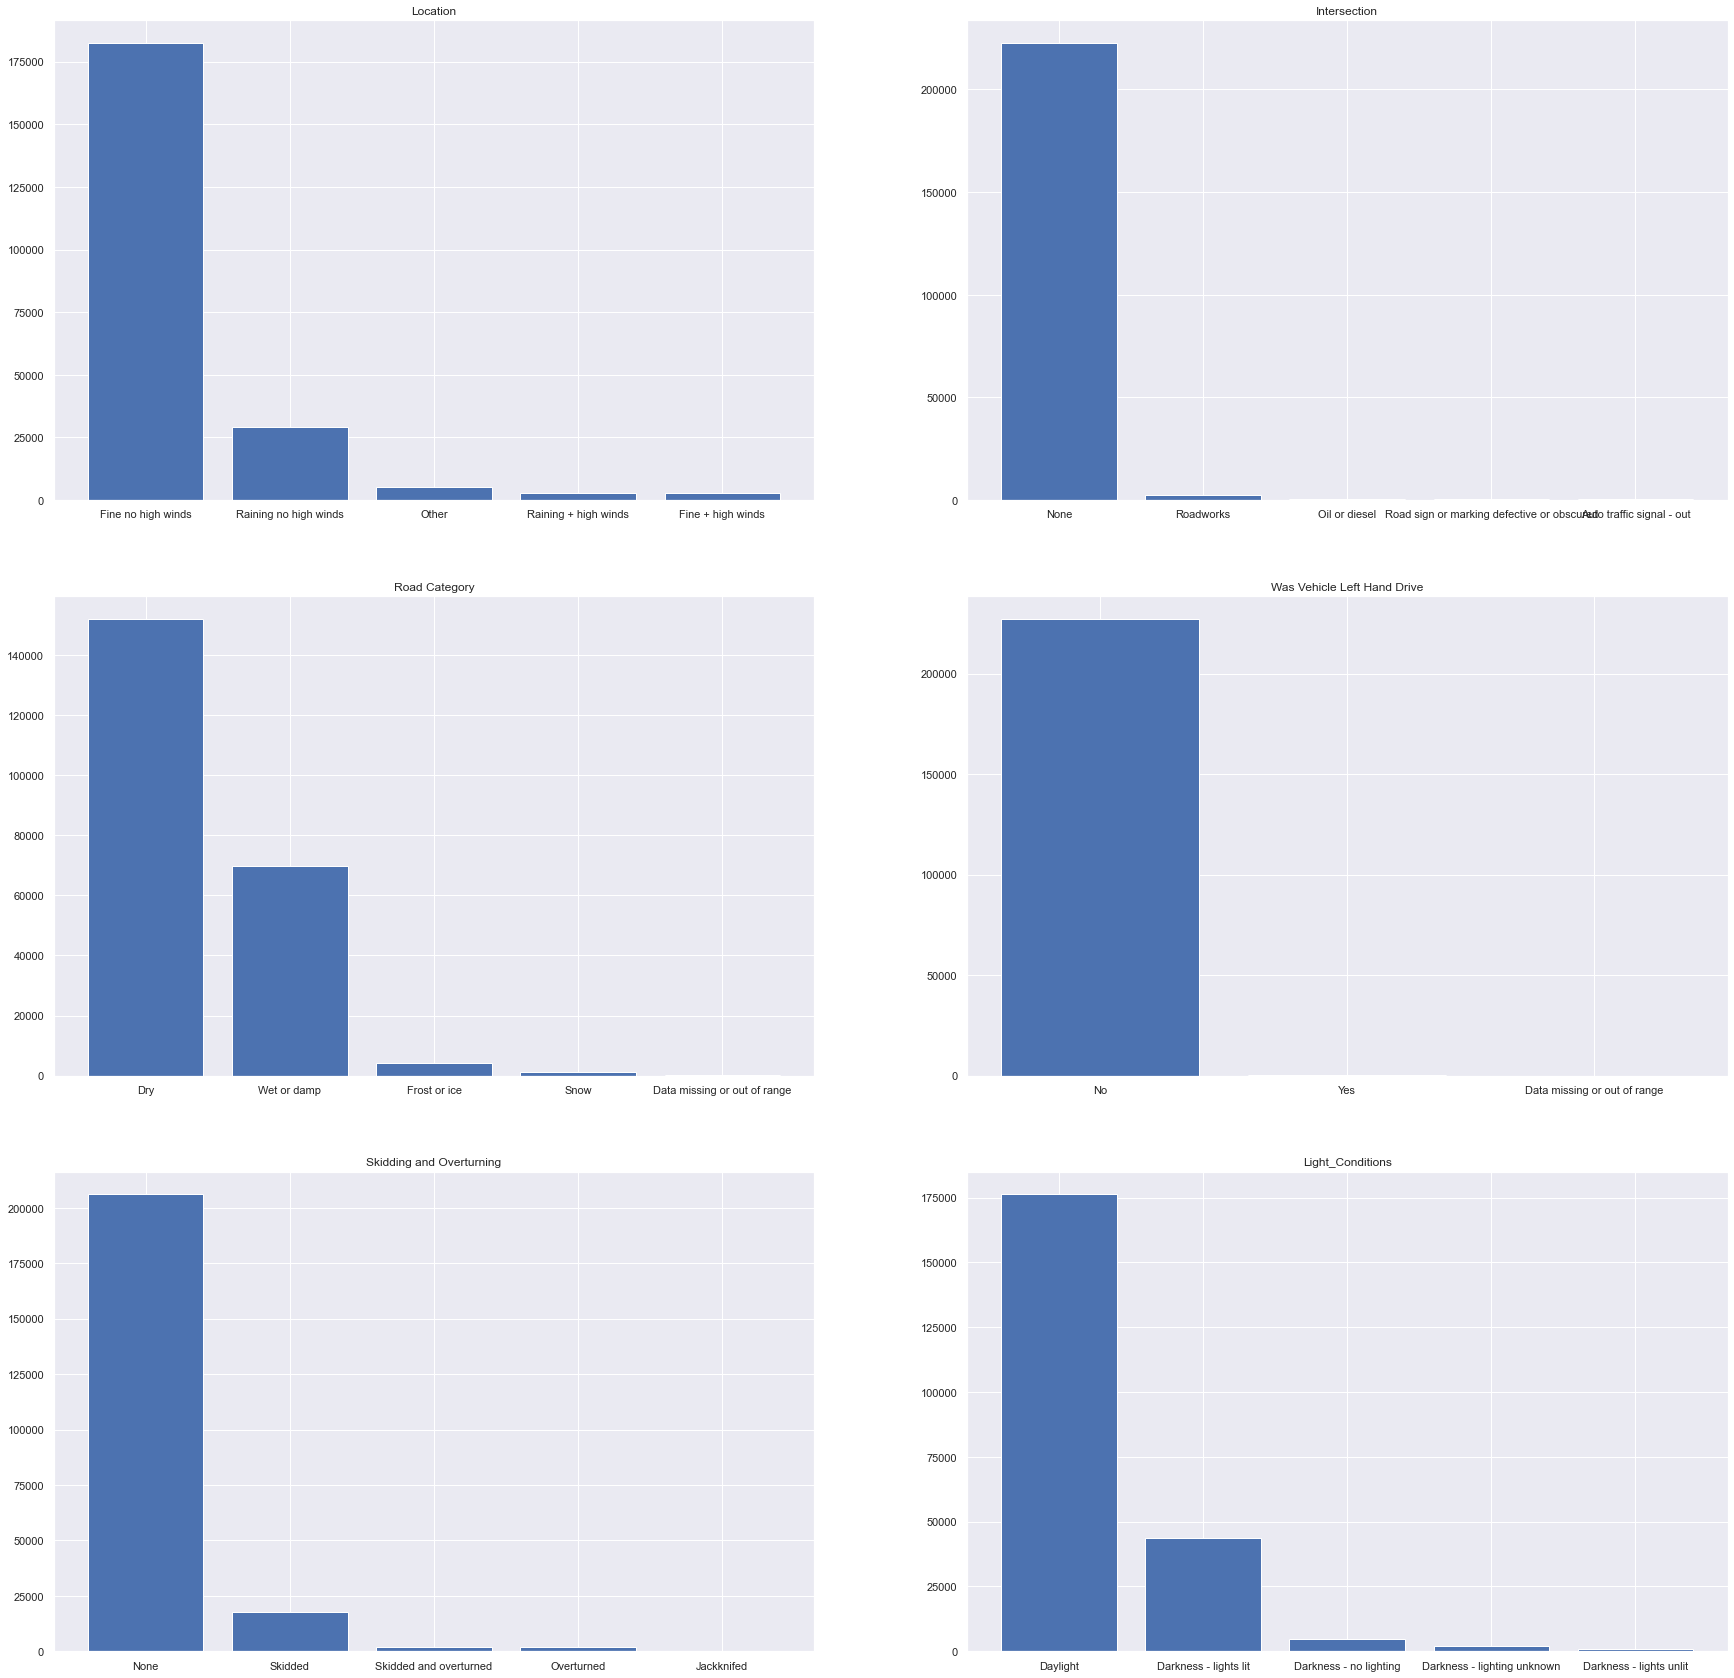

In [34]:
fig, axs = plt.subplots(3, 2,figsize=(30,30))
axs[0, 0].bar(Weather_Conditions.index, Weather_Conditions)
axs[0, 0].set_title('Location')
axs[0, 1].bar(Special_Conditions_at_Site.index, Special_Conditions_at_Site)
axs[0, 1].set_title('Intersection')
axs[1, 0].bar(Road_Surface_Conditions.index, Road_Surface_Conditions)
axs[1, 0].set_title('Road Category')
axs[1, 1].bar(Was_Vehicle_Left_Hand_Drive.index, Was_Vehicle_Left_Hand_Drive)
axs[1, 1].set_title('Was Vehicle Left Hand Drive')
axs[2, 0].bar(Skidding_and_Overturning.index, Skidding_and_Overturning)
axs[2, 0].set_title('Skidding and Overturning')
axs[2, 1].bar(Light_Conditions.index, Light_Conditions)
axs[2, 1].set_title('Light_Conditions')
              
              

# Graph 2: Boxplot to identify outliers

This next graph is drawn to identify any outliers in the data

Number_of_Vehicles is measures the total number of vehicles involved in an accident
Number_of_Casualties measures the number of people affected in a certain accident

I wanted to check if there are any outliers within these 2 columns

The boxplot is used as it can help to easily visualise the outliers in each column.

In [35]:
# define numerical columns
num_cols = ['Number_of_Vehicles', 'Number_of_Casualties']

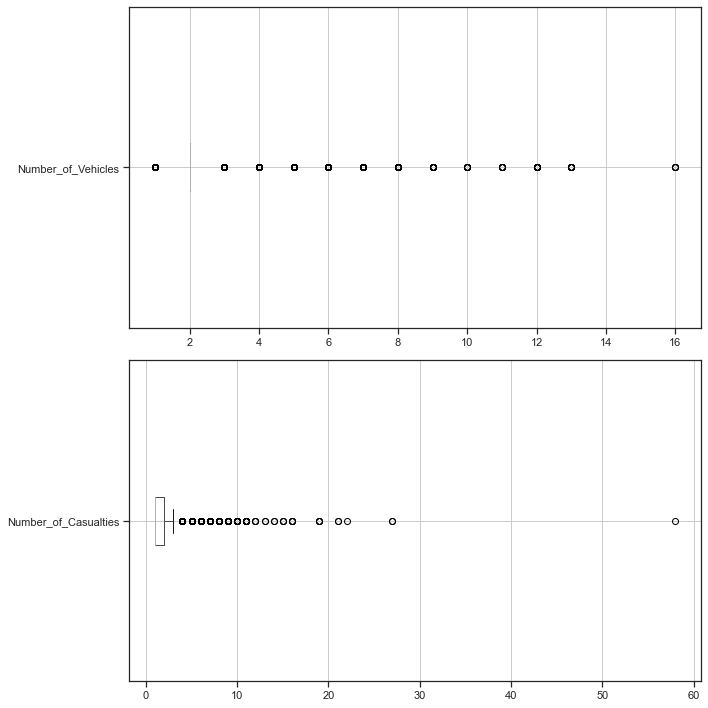

In [36]:
# plotting boxplots
sns.set(style='ticks')
fig, axes = plt.subplots(2,1, figsize=(10,10))

for ax, col in zip(axes, num_cols):
    df.boxplot(column=col, grid=True, vert=False, ax=ax)
    plt.tight_layout();

# Graph 3: Bar Graph to show the overall trend in road accidents over the years

This graph shows the total count of road accidents over the years, a bar graph is used as it can clearly show that the total number of accidents are increasing with each year and I have also placed a trend line for further visualisation.

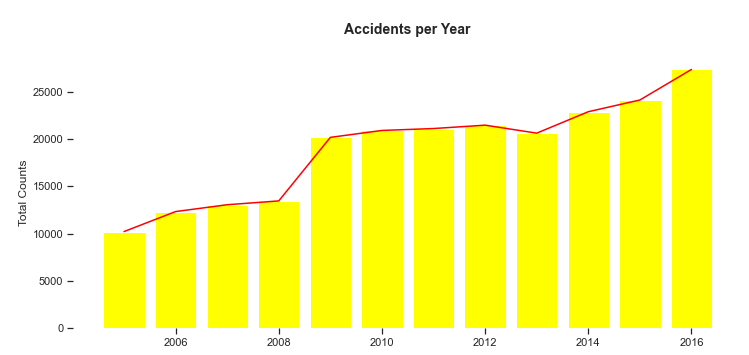

In [37]:
#overall accidents per year
yearly_count = df['Date'].dt.year.value_counts().sort_index(ascending = False)

# prepare plot
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(12,5))

# plot
ax.bar(yearly_count.index, yearly_count.values, color='yellow')
ax.plot(yearly_count, linestyle='solid', color='red')
ax.set_title('\nAccidents per Year\n', fontsize=14, fontweight='bold')
ax.set(ylabel='\nTotal Counts')

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

# Graph 4: Overall Severity of the road accidents

This doughnut pie chart shows the overall severity of every accident recorded. Accident Severity are divided into three categories: Slight, Severe and Fatal.

Slight accidents are where the accident is not such a big deal (small scratch, bump), the damage to the vehicles and the victims is very minimal

Severe accidents are quite serious where the vehicles are thouroughly damaged and the victims may have sustained serious injuries

Fatal accidents are those where at least one victim has lost their life due to the accident


As we can see from the chart below, most of the accidents are categorised as Slight, followed by a few Serious accidents and finally a very small percentage of Fatal accidents

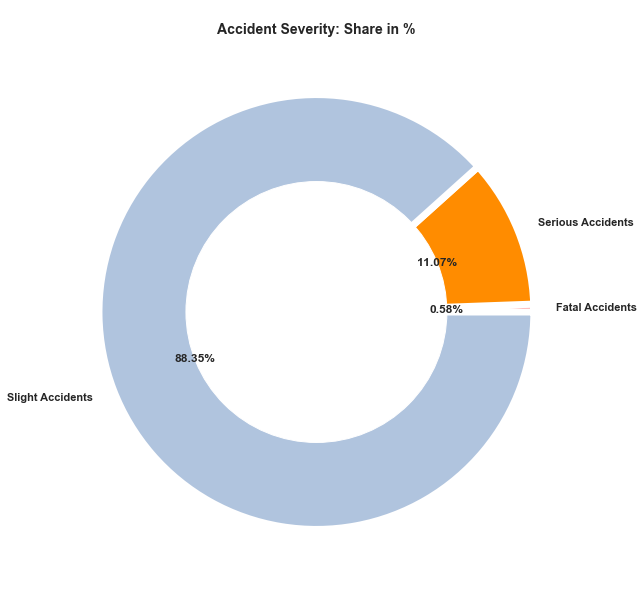

In [38]:
# assign the data
fatal   = df.Accident_Severity.value_counts()['Fatal']
serious = df.Accident_Severity.value_counts()['Serious']
slight  = df.Accident_Severity.value_counts()['Slight']

names = ['Fatal Accidents','Serious Accidents', 'Slight Accidents']
size  = [fatal, serious, slight]
explode = (0.2, 0, 0)

# create a pie chart
plt.pie(x=size, labels=names, colors=['red', 'darkorange', 'lightsteelblue'], 
        autopct='%1.2f%%', pctdistance=0.6, textprops=dict(fontweight='bold'),
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(10,10)
fig.gca().add_artist(my_circle)
plt.title('\nAccident Severity: Share in %', fontsize=14, fontweight='bold')
plt.show()

# Graph 5: Trend of Accident Severity Per Month Over the Years


This graph shows three separate lines which each denote one of the accident severity categories. The purpose of this graph is to visualise any trend in each category of accident over the years. 


PREPARATION

Firstly, a smaller dataframe with only "Date", "Accident_Index" and "Accident_Severity" is created, then, the accidents in each accident severity is grouped by a monthly measurement.

Secondly, each accident is split on the category of Accident_Severity and a new dataframe is created.

Finally, each of the accidents based on severity is divided by 100 to create a percentage which will be used to measure the trend in accident severity over the years.



In [39]:
sub_df = df[['Date', 'Accident_Index', 'Accident_Severity']]

# pull out the year
year = sub_df['Date'].dt.year
month = sub_df['Date'].dt.month

# groupby year and severities
count_of_fatalities = sub_df.set_index('Date').groupby([pd.Grouper(freq='M'), 'Accident_Severity']).size()

# build a nice table
fatalities_table = count_of_fatalities.rename_axis(['Month', 'Accident_Severity'])\
                                      .unstack('Accident_Severity')\
                                      .rename({1:'fatal', 2:'serious', 3:'slight'}, axis='columns')
fatalities_table.head()

Accident_Severity,Fatal,Serious,Slight
Month,,,
2005-01-31,5,85,640
2005-02-28,3,53,545
2005-03-31,2,50,564
2005-04-30,4,63,725
2005-05-31,8,89,789


In [40]:
fatalities_table['sum'] = fatalities_table.sum(axis=1)
fatalities_table = fatalities_table.join(fatalities_table.div(fatalities_table['sum'], axis=0), rsuffix='_percentage')
fatalities_table.head()

Accident_Severity,Fatal,Serious,Slight,sum,Fatal_percentage,Serious_percentage,Slight_percentage,sum_percentage
Month,,,,,,,,
2005-01-31,5,85,640,730,0.006849,0.116438,0.876712,1.0
2005-02-28,3,53,545,601,0.004992,0.088186,0.906822,1.0
2005-03-31,2,50,564,616,0.003247,0.081169,0.915584,1.0
2005-04-30,4,63,725,792,0.005051,0.079545,0.915404,1.0
2005-05-31,8,89,789,886,0.009029,0.100451,0.890519,1.0


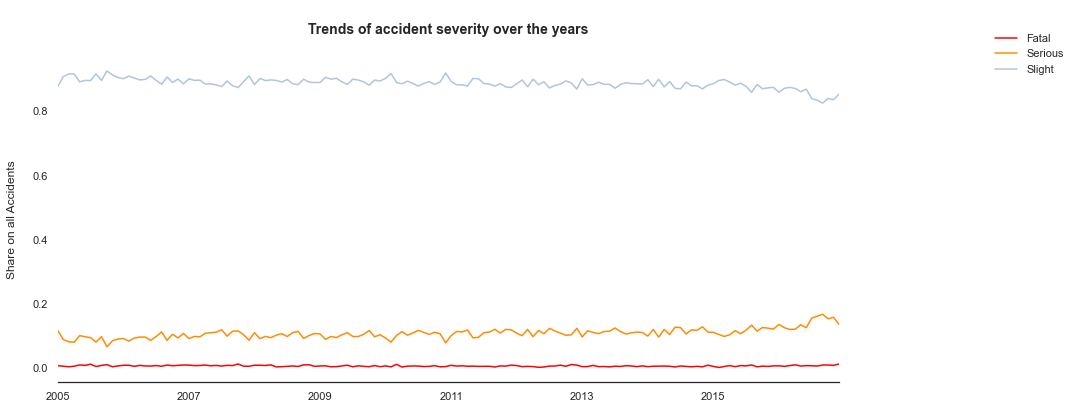

In [41]:
# prepare data
sub_df = fatalities_table[['Fatal_percentage', 'Serious_percentage', 'Slight_percentage']]

# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14,6))
colors=['red', 'darkorange', 'lightsteelblue']

# plot
sub_df.plot(color=colors, ax=ax)
ax.set_title('\nTrends of accident severity over the years\n', fontsize=14, fontweight='bold')
ax.set(ylabel='Share on all Accidents\n', xlabel='')
ax.legend(labels=['Fatal', 'Serious', 'Slight'], 
          bbox_to_anchor=(1.3, 1.1), frameon=False)

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=False);

As shown in the graph above, the trend of each category of accident severity is relatively the same over the years.

# Graph 7: Correlation Matrix


This heat map shows the correlation between the different factors involved in the accidents

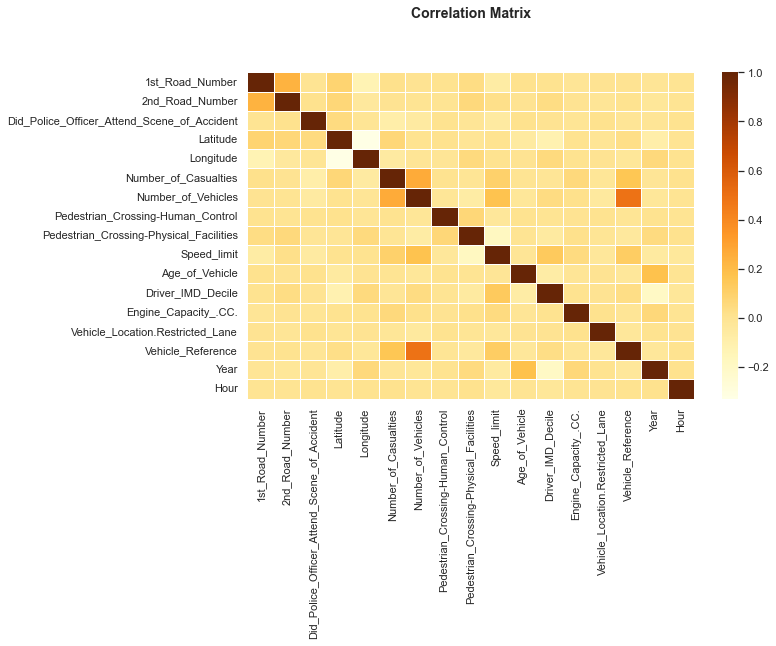

In [42]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),linewidths=.5,cmap="YlOrBr")
plt.title("Correlation Matrix\n\n\n", fontsize = 14, fontweight = 'bold')
plt.show()

# Graph 8: Smaller Correlation Matrix with desired Columns

I have created a smaller dataframe with certain columns that have interested me and encouraged me to explore a little further into the correlations between these factors.
Therefore, i have plotted a second correlation matrix with just the desired columns.

The desired columns are shown below followed by the smaller correlation matrix

In [43]:
df2 = df[['Accident_Index', '1st_Road_Class','Day_of_Week', 'Junction_Detail','Light_Conditions', 'Number_of_Casualties',
          'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit',
          'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Age_of_Vehicle',
          'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'make', 'Engine_Capacity_.CC.', 'Sex_of_Driver',
          'Skidding_and_Overturning', 'Vehicle_Manoeuvre', 'Vehicle_Type', 'Accident_Severity'
         ]]

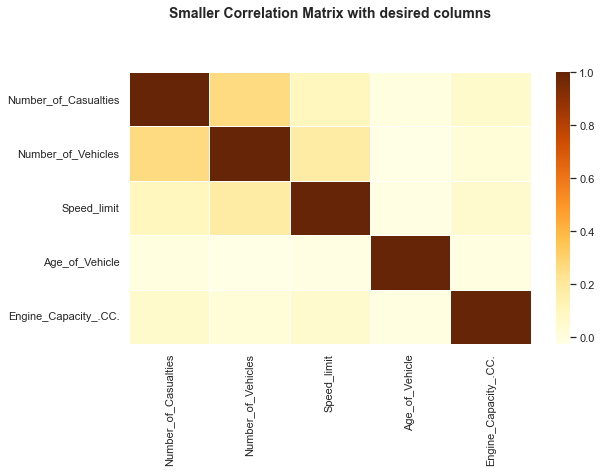

In [44]:
plt.figure(figsize=(9,5))
sns.heatmap(df2.corr(),linewidths=.5,cmap="YlOrBr")
plt.title('Smaller Correlation Matrix with desired columns\n\n\n' , fontsize = 14, fontweight = 'bold')
plt.show()

# Insights


The following section is focused on a determining the different causes of accidents. It is a deeper exploration on a subset of this dataset which allows us to answer some questions regarding road accidents.


# Question 1: Which road type has the most accidents?

The type of road is an important factor to consider when investigating accidents as it speaks to the overall infrastructure of the city and how the roads are built. This could also be a guideline to the government to increase the types of roads which typically have fewer accidents.


Answer: "Dual Carriageway" has the most number of accidents followed by "Slip roads", the next accident prone road is the "Single Carriageway" and finally, "Roundabouts" and "One Way Streets" have the same percentage of accidents.

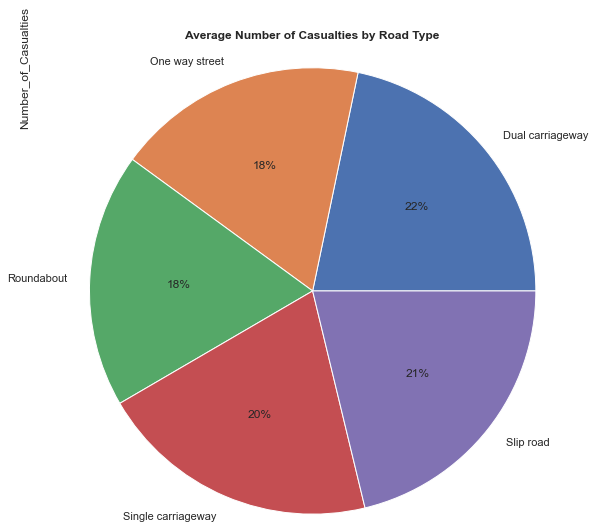

In [45]:
# check road type
df.groupby('Road_Type')['Number_of_Casualties'].mean().plot(kind='pie', autopct='%.0f%%', figsize=(10,5))
plt.ylim((1,1))
plt.title('\nAverage Number of Casualties by Road Type\n', fontweight='bold')
sns.despine(top=True, right=True, left=True, bottom=True);

# Question 2: Why are people on the road?

This insight helps us to understand the mindset of the driver prior to the accident

As we can see from the chart below, a staggering 95% of accidents happen when the drivers are on the road for something relating to their work. This indicates that pressure of not being late and haivng to show up to work on time is a major factor that induces stress to the drivers which in turn leads to road accidents.

This could be prevented by planning their time, and journeys better which would allow them to start earlier and to not be in a rush.

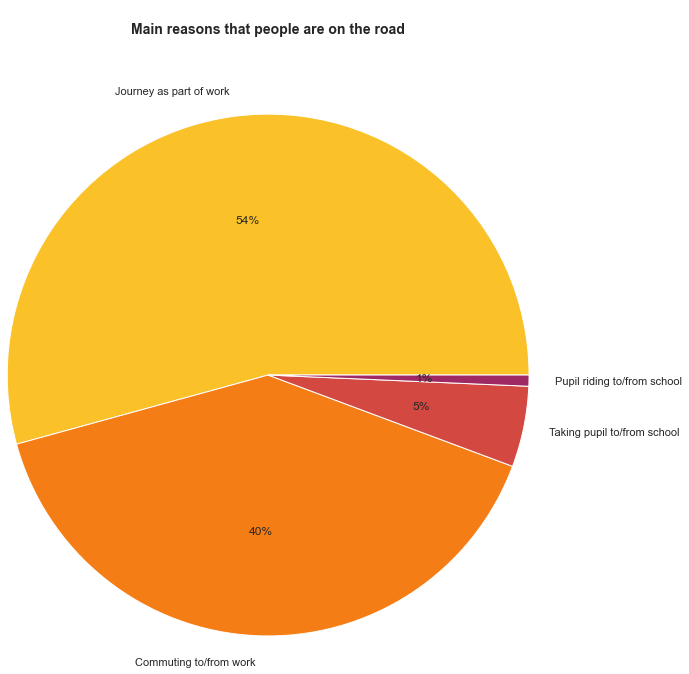

In [46]:
journey_count = df['Journey_Purpose_of_Driver'].value_counts()
colors = sns.color_palette('inferno_r')
plt.pie(journey_count, labels = journey_count.index, colors = colors , autopct='%.0f%%', radius = 3)
plt.title('\nMain reasons that people are on the road\n\n\n\n\n\n\n\n\n\n\n\n\n\n', fontsize = 14, fontweight='bold')
plt.show()

# Question 3: Which Gender and Age Group causes the most accidents?

This insight attempts to answer 2 burning questions:

Which gender drives safely?

Do young drivers cause more accidents than older drivers?


A simple bar chart is used for the first question as it displays without a doubt that male drivers cause more than double the number of accidents than female drivers.

A side-by-side bar is used for the second question to show the gender and age group of drivers who are most involved in road accidents. This graph shows that most of the accidents are caused by people between 26 - 65



[]

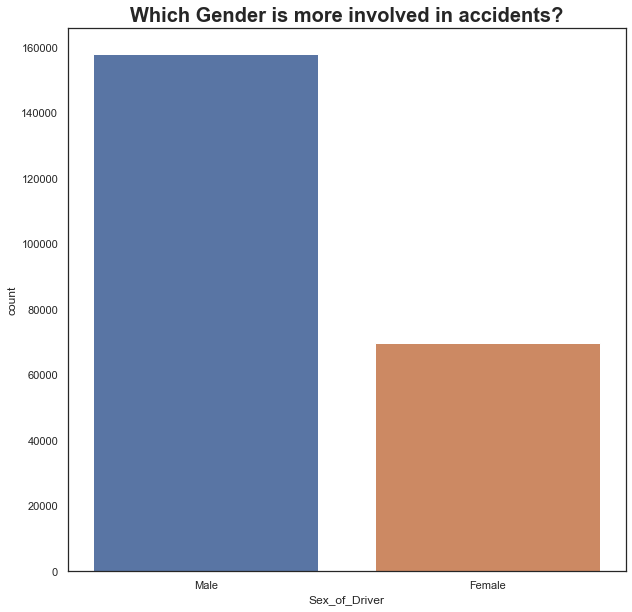

In [47]:
plt.figure(figsize=(10,10))
plt.title('Which Gender is more involved in accidents?', fontsize=20, fontweight='bold')
sns.countplot(df['Sex_of_Driver'])
plt.plot()

In [48]:
# create a new dataframe
drivers = df.groupby(['Age_Band_of_Driver', 'Sex_of_Driver']).size().reset_index()
# rename the columns
drivers.columns = ['Age_Band_of_Driver', 'Sex_of_Driver', 'Count']
drivers

,Age_Band_of_Driver,Sex_of_Driver,Count
0,16 - 20,Female,4683
1,16 - 20,Male,9071
2,21 - 25,Female,9618
3,21 - 25,Male,16873
4,26 - 35,Female,18247
5,26 - 35,Male,39571
6,36 - 45,Female,17813
7,36 - 45,Male,39821
8,46 - 55,Female,13064
9,46 - 55,Male,31969


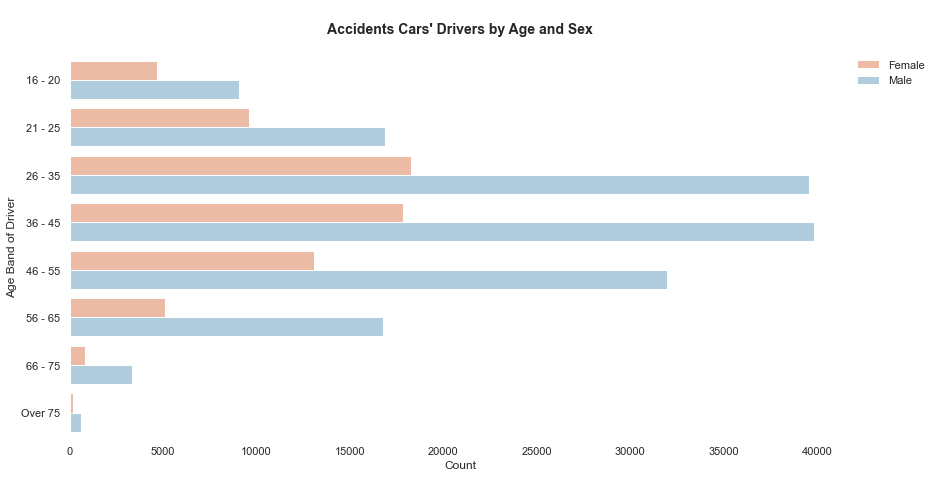

In [49]:
# seaborn barplot
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(y='Age_Band_of_Driver', x='Count', hue='Sex_of_Driver', data = drivers, palette='RdBu')
ax.set_title('\nAccidents Cars\' Drivers by Age and Sex\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Count', ylabel='Age Band of Driver')
ax.legend(bbox_to_anchor=(1.1, 1.), borderaxespad=0., frameon=False)

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);

# Question 4: Which day is the worst day for accidents?


This insight aims to answer if the day of the week has any relationship between the number of people involved in accidents.

I honestly was expecting Saturday to be the highest because most people are out during the weekend which leads to higher traffic jams and more traffic collitions, however, according to this graph, Wednesday is the worst day for accidents.

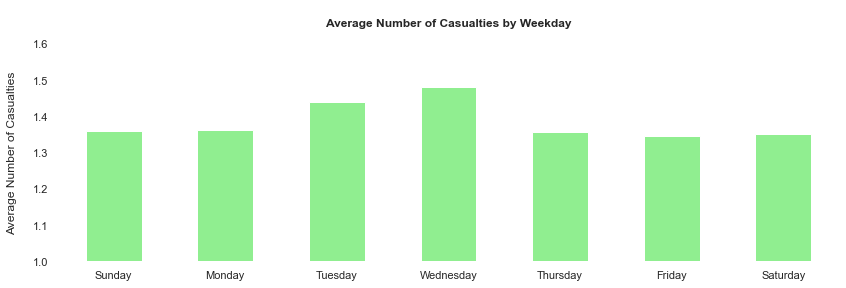

In [50]:
df.groupby('Day_of_Week')['Number_of_Casualties'].mean().plot(kind='bar', color='lightgreen', 
                                                              figsize=(14,4), grid=False)
plt.xticks(np.arange(7), 
           ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], 
           rotation='horizontal')
plt.ylim((1.0,1.6))
plt.xlabel(''), plt.ylabel('Average Number of Casualties\n')
plt.title('\nAverage Number of Casualties by Weekday\n', fontweight='bold')
sns.despine(top=True, right=True, left=True, bottom=True);

# Question 5: At what time do most accidents occur?

This is a three-part insight

The first one is to visualise at what time of the day do most accidents occur

The second step is using the previously defined (time_of_day) function to divide the day up into categories of

Rush Hours, Office Hours, After Work Rush, Evening and Night

The second step helps us to further understand the mindset of drivers in terms of why the accident has happened on a certain time of the day

The third step is to categorise each accident based on the severity to visualise how the time of day causes different type of accidents.

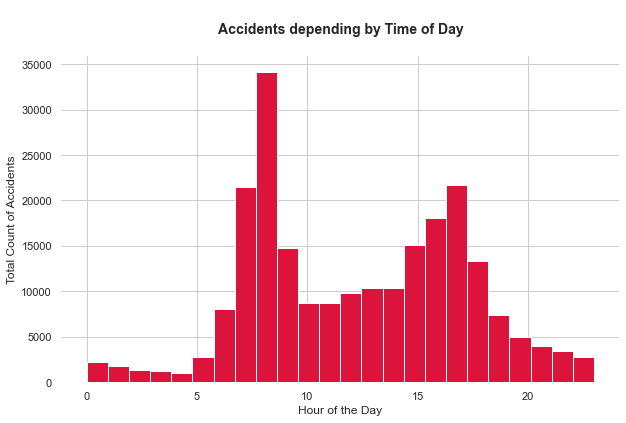

In [51]:
# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,6))

# plot
df.Hour.hist(bins=24, ax=ax, color='crimson')
ax.set_title('\nAccidents depending by Time of Day\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Hour of the Day', ylabel='Total Count of Accidents')

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);

According to the graph above, we can clearly see that most of the accidents happen in the morning and in the evening

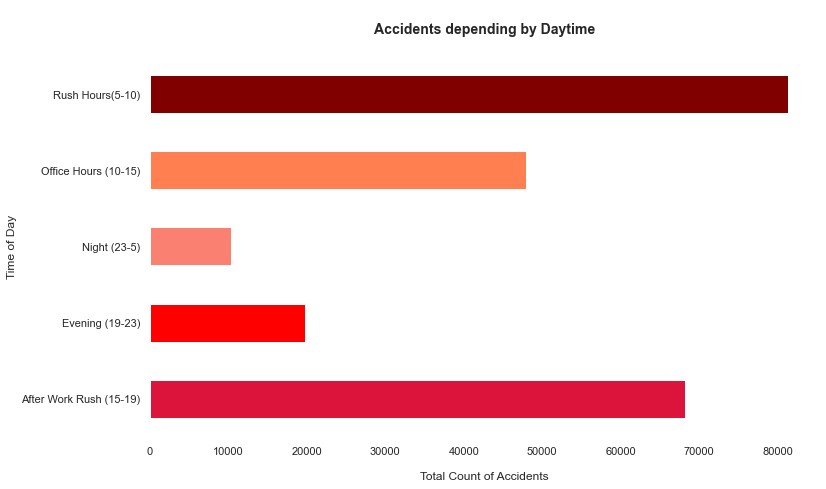

In [52]:
# prepare dataframe
order = ['Rush Hours (5 - 10)' , 'Office Hours (10-15)' , 'After Work Rush (15-19)' , 'Evening (19-23)', 'Night (23-5)']
df_sub = df.groupby('Daytime').size().sort_index(ascending = True)

# prepare barplot
fig, ax = plt.subplots(figsize=(12, 7))
colors = ['crimson', 'red', 'salmon', 'coral', 'Maroon']

# plot
df_sub.plot(kind='barh', ax=ax, color=colors)
ax.set_title('\nAccidents depending by Daytime\n', fontsize=14, fontweight='bold')
ax.set(xlabel='\nTotal Count of Accidents', ylabel='Time of Day')

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);

The above graph shows us that most accidents occur during "Rush Hours", and "After Work Rush", which confirms that people are stressed about getting to work on time that they drive recklessly and that they are so excited to get back home from work that they again drive recklessly.

Getting to and from work can be considered the number one factor leading to road accidents in the UK.

# Preparing dataframe to categorise accidents within different times of the day based on severity

In [53]:
# prepare dataframe with simple counts
counts = df.groupby(['Daytime', 'Accident_Severity']).size()

counts = counts.rename_axis(['Daytime', 'Accident_Severity'])\
                                .unstack('Accident_Severity')\
                                .rename({1:'fatal', 2:'serious', 3:'slight'}, axis='columns')
counts

Accident_Severity,Fatal,Serious,Slight
Daytime,,,
After Work Rush (15-19),338,7773,60059
Evening (19-23),129,2435,17248
Night (23-5),127,1451,8805
Office Hours (10-15),300,4799,42836
Rush Hours(5-10),423,8741,72100


In [54]:
# prepare dataframe with shares
counts['sum'] = counts.sum(axis=1)
counts = counts.join(counts.div(counts['sum'], axis=0), rsuffix=' in %')
counts_share = counts.drop(columns=['Fatal', 'Serious', 'Slight', 'sum', 'sum in %'], axis=1)
counts_share

Accident_Severity,Fatal in %,Serious in %,Slight in %
Daytime,,,
After Work Rush (15-19),0.004958,0.114024,0.881018
Evening (19-23),0.006511,0.122905,0.870583
Night (23-5),0.012232,0.139748,0.848021
Office Hours (10-15),0.006258,0.100115,0.893627
Rush Hours(5-10),0.005205,0.107563,0.887232


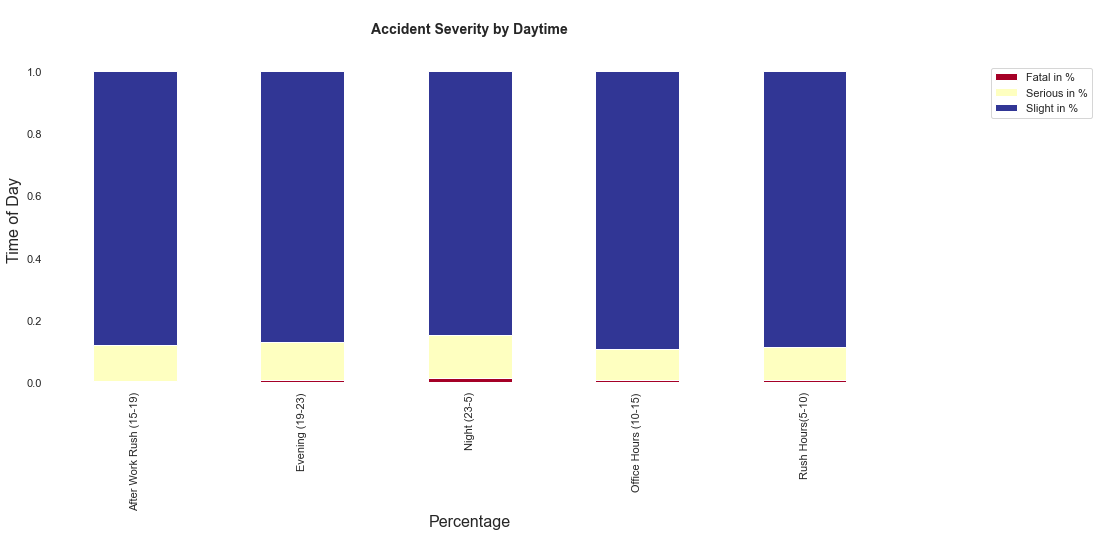

In [55]:
# prepare barplot
fig, ax = plt.subplots(figsize=(15, 6))

# plot
counts_share.plot(kind='bar', ax = ax, stacked=True, cmap='RdYlBu')
ax.set_title('\nAccident Severity by Daytime\n', fontsize=14, fontweight='bold')
ax.set_xlabel('Percentage', fontsize = 16)
ax.set_ylabel('Time of Day', fontsize = 16)
ax.legend(bbox_to_anchor=(1.25, 0.98), frameon = True)

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);

The above graph is a stacked bar which shows the percentages of each typy of accident in different times of the day.

We can note that the highest percentage of fatal accidents occur at night, this may be because of Drinking and Driving after visiting pubs and nightclubs.

Rash driving at night is a growing concern in today's world.


# Question 6: What was the action of the driver that led to the accident?

This insight aims to answer an important question. What was the last thing that the driver did before meeting with the accident itself? This category is labelled as "Vehicle_Manoeuvre" in the dataset and describes what the driver was doing just moments before the accident itself happened.

In [56]:
import squarify

In [57]:
df_plot = df.groupby('Vehicle_Manoeuvre').size()\
                                                .reset_index(name='counts')\
                                                    .sort_values(by='counts', ascending=False)
                                                        
df_plot = df_plot[df_plot.counts > 10000]
df_plot

,Vehicle_Manoeuvre,counts
4,Going ahead other,93413
14,Turning right,37776
16,Waiting to go - held up,19409
12,Slowing or stopping,17273
6,Moving off,13713
13,Turning left,11711


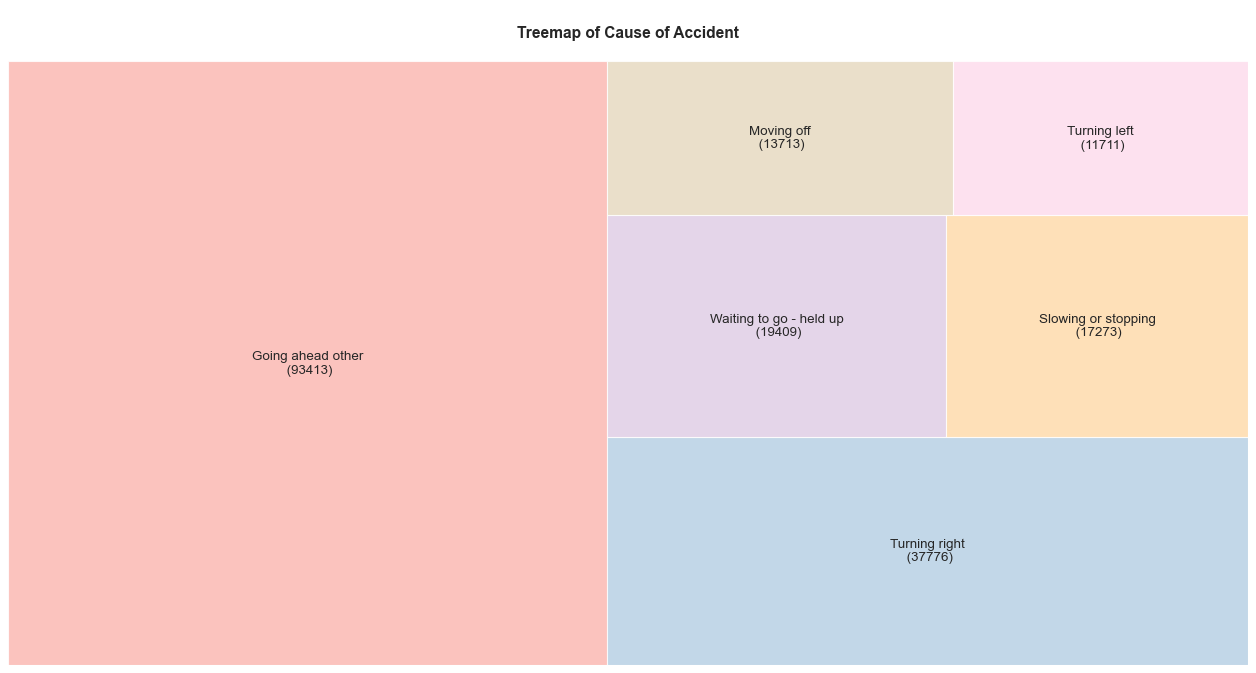

In [58]:
# prepare plot
labels = df_plot.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df_plot['counts'].values.tolist()
colors = [plt.cm.Pastel1(i/float(len(labels))) for i in range(len(labels))]

# plot
plt.figure(figsize=(20,10), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color = colors, alpha=.8)

# Decorate
plt.title('\nTreemap of Cause of Accident\n', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

As we can see from the treemap above, the most obivious action that led to an accident was going ahead the other car, AKA, trying to overtake a driver, this action usually involves a rapid increase in speed which may lead to the driver losing control of the vehicle and ultimately causing an accident

# Conclusion


This assignment has explored several details of road accidents in the UK and the different factors that have led to the accidents taking place.